Query Benchamark

In [187]:
import pyodbc
import pandas as pd
conn= pyodbc.connect(
'Driver={SQL Server Native Client 11.0};'
'Server=MSI;'
'Database=Backup6;'
'MARS_Connection=Yes;'
'Trusted_Connection=yes;'
)

In [284]:
import pandas as pd
from py2neo import Node,Relationship,Graph, database,NodeMatcher 
import time 

Query in Neo4J DisGeNet

In [285]:
graph=Graph()# or Graph('bolt://neo4j@localhost:7687')

In [286]:
G_in_S=[]
D_in_G=[]
G_2_S=[]
s=34
for i in range(1,17):
    
    for r in range(0,100):
        runtime=time.time()
        graph.run('Match(s:Sample)-[:EXPRESSED]-(g:Gene) where ID(s)=$id return g',id=44637 )
        G_in_S.append([s,round(time.time()-runtime,4)])

        runtime=time.time()
        graph.run('Match(s:Sample)-[:EXPRESSED]-(g:Gene) where ID(s)=$id match (g)-[:GDA]-(d:Disease) return g,d',id=44637 )
        D_in_G.append([s,round(time.time()-runtime,4)])

        runtime=time.time()
        graph.run('MATCH (s1:Sample)-[:EXPRESSED]->(g:Gene)<-[:EXPRESSED]-(s2:Sample)  where ID(s1)=$id1 and ID(s2)=$id2  return g.ENSEMBL',id1=44637 ,id2=44638)
        G_2_S.append([s,round(time.time()-runtime,4)])

    s=s-2
    id1=(44669-2*(i-1))
    id2=(44670-2*(i-1))
    graph.run('Match(s:Sample) where ID(s)=$id  detach delete s',id=id1)
    graph.run('Match(s:Sample) where ID(s)=$id  detach delete s',id=id2)

#repeat query one last time
for r in range(0,100):
    runtime=time.time()
    graph.run('Match(s:Sample)-[:EXPRESSED]-(g:Gene) where ID(s)=$id return g',id=44637)
    G_in_S.append([s,round(time.time()-runtime,4)])

    runtime=time.time()
    graph.run('Match(s:Sample)-[:EXPRESSED]-(g:Gene) where ID(s)=$id match (g)-[:GDA]-(d:Disease) return g,d',id=44637)
    D_in_G.append([s,round(time.time()-runtime,4)])

    runtime=time.time()
    graph.run('MATCH (s1:Sample)-[:EXPRESSED]->(g:Gene)<-[:EXPRESSED]-(s2:Sample)  where ID(s1)=$id1 and ID(s2)=$id2  return g.ENSEMBL',id1=44637 ,id2=44638)
    G_2_S.append([s,round(time.time()-runtime,4)])

Query in SQL

In [188]:
query_Gene_in_s='''SELECT Genes.Gene_ENGS
from Sample_Description inner join Samples_Regulations ON Sample_Description.Sample_ID = Samples_Regulations.Sample_ID
INNER JOIN Genes ON Samples_Regulations.Gene_ID = Genes.Gene_ID
where Sample_Description.Sample_ID=1 '''

Query_Disease_in_g='''SELECT Genes.Gene_ENGS, Disease.Disease_Name
from Sample_Description 
INNER JOIN Samples_Regulations ON Sample_Description.Sample_ID = Samples_Regulations.Sample_ID
INNER JOIN Genes ON Samples_Regulations.Gene_ID = Genes.Gene_ID
INNER JOIN GDA ON Genes.Gene_ID=GDA.Gene_ID 
INNER JOIN Disease ON GDA.DIsease_ID=Disease.Disease_ID
where Sample_Description.Sample_ID=1 '''

Query_g_in_2s=''' SELECT  Genes.Gene_ENGS, Disease.Disease_Name
from Sample_Description 
INNER JOIN Samples_Regulations ON Sample_Description.Sample_ID = Samples_Regulations.Sample_ID
INNER JOIN Genes ON Samples_Regulations.Gene_ID = Genes.Gene_ID
INNER JOIN GDA ON Genes.Gene_ID=GDA.Gene_ID 
INNER JOIN Disease ON GDA.DIsease_ID=Disease.Disease_ID
where Sample_Description.Sample_ID=1
INTERSECT
SELECT  Genes.Gene_ENGS, Disease.Disease_Name
from Sample_Description 
INNER JOIN Samples_Regulations ON Sample_Description.Sample_ID = Samples_Regulations.Sample_ID
INNER JOIN Genes ON Samples_Regulations.Gene_ID = Genes.Gene_ID
INNER JOIN GDA ON Genes.Gene_ID=GDA.Gene_ID 
INNER JOIN Disease ON GDA.DIsease_ID=Disease.Disease_ID
where Sample_Description.Sample_ID=2 '''

delete_Query='''Delete from Samples_Regulations where Samples_Regulations.Sample_ID=?;
Delete from Sample_Description where Sample_Description.Sample_ID=?;'''

In [191]:
SQL_G_in_S=[]
SQL_D_in_G=[]
SQL_G_2_S=[]
s=34
#cursor= conn.cursor()
for i in range(1,17):
    cursor= conn.cursor()
    for r in range(0,100):

        runtime=time.time()
        cursor.execute(query_Gene_in_s)
        SQL_G_in_S.append([s,round(time.time()-runtime,4)])
        conn.commit()

        runtime=time.time()
        cursor.execute(Query_Disease_in_g)
        SQL_D_in_G.append([s,round(time.time()-runtime,4)])
        conn.commit()

        runtime=time.time()
        cursor.execute(Query_g_in_2s)
        SQL_G_2_S.append([s,round(time.time()-runtime,4)])
        conn.commit()

    s=s-2
    id1=(34-2*(i-1))
    id2=(33-2*(i-1))
    cursor= conn.cursor()
    cursor.execute(delete_Query,id1,id1)
    conn.commit()

    cursor= conn.cursor()
    cursor.execute(delete_Query,id2,id2)
    conn.commit()

#repeat query one last time
for r in range(0,100):

    runtime=time.time()
    cursor.execute(query_Gene_in_s)
    SQL_G_in_S.append([s,round(time.time()-runtime,4)])
    conn.commit()

    runtime=time.time()
    cursor.execute(Query_Disease_in_g)
    SQL_D_in_G.append([s,round(time.time()-runtime,4)])
    conn.commit()

    runtime=time.time()
    cursor.execute(Query_g_in_2s)
    SQL_G_2_S.append([s,round(time.time()-runtime,4)])
    conn.commit()

In [292]:
G_in_S=pd.DataFrame(G_in_S)
D_in_G=pd.DataFrame(D_in_G)
G_2_S=pd.DataFrame(G_2_S)

SQL_G_in_S=pd.DataFrame(SQL_G_in_S)
SQL_D_in_G=pd.DataFrame(SQL_D_in_G)
SQL_G_2_S=pd.DataFrame(SQL_G_2_S)

Plot all data

In [289]:
import matplotlib.pyplot as plt
import numpy as np

In [95]:
x=G_2_S[0].unique()
len(x)

17

In [296]:
neo4_mean_G_in_S=G_in_S.groupby([0]).mean()
neo4_sd_G_in_S=G_in_S.groupby([0]).std()
len(neo4_mean_G_in_S),len(neo4_sd_G_in_S)

(17, 17)

In [298]:
x=r_G_2_S[0].unique()

In [96]:
sql_mean_G_in_S=SQL_G_in_S.groupby([0]).mean()
sql_sd_G_in_S=SQL_G_in_S.groupby([0]).std()
len(sql_mean_G_in_S),len(sql_sd_G_in_S)

(17, 17)

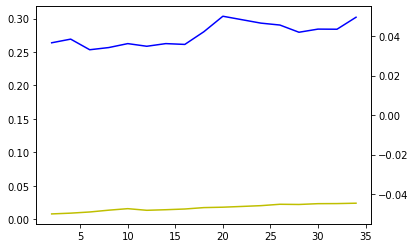

In [299]:
fig1,ax1=plt.subplots()
ax2=ax1.twinx()
curve1=ax1.plot(x,neo4_mean_G_in_S, label='Query time Genes in 1 sample Neo4j', color='b')
curve2=ax1.plot(x,sql_mean_G_in_S, label='Query time Genes in 1 sample SQL', color='y')
plt.plot()
plt.show()

In [300]:
from collections import defaultdict

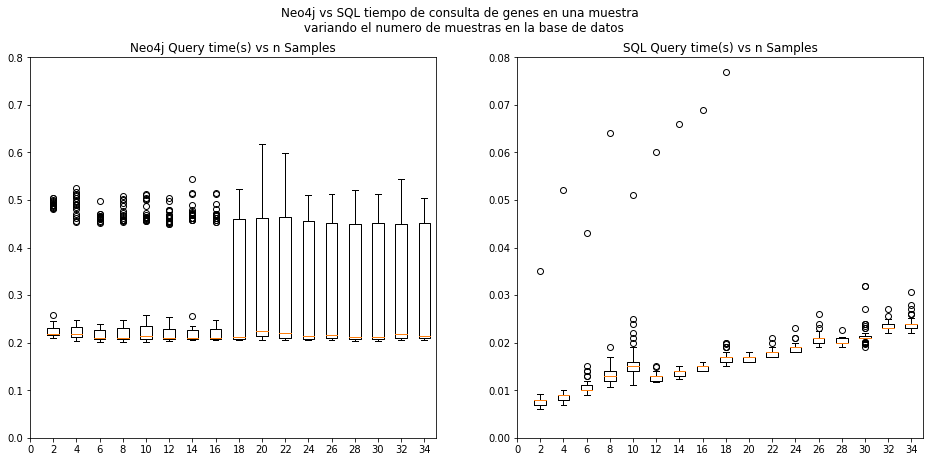

In [301]:
r_G_in_S = G_in_S.iloc[::-1]
r_SQL_G_in_S = SQL_G_in_S.iloc[::-1]
tuples1 = [tuple(x) for x in r_G_in_S.to_numpy()]
tuples2 = [tuple(x) for x in r_SQL_G_in_S.to_numpy()]

d1 = defaultdict(list)
for x, y in tuples1:
    d1[x].append(y)
d2 = defaultdict(list)
for x, y in tuples2:
    d2[x].append(y)
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(16)
#'Neo4j vs SQL Query time for Genes in 1 Sample varying Samples number in database'
fig.suptitle('Neo4j vs SQL tiempo de consulta de genes en una muestra \n variando el numero de muestras en la base de datos')
ax1.boxplot(d1.values())
ax1.title.set_text('Neo4j Query time(s) vs n Samples')
ax1.set_ylim([0, 0.8])
ax2.boxplot(d2.values())
ax2.title.set_text('SQL Query time(s) vs n Samples')
ax2.set_ylim([0, 0.080])

plt.sca(ax1)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.sca(ax2)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.show()

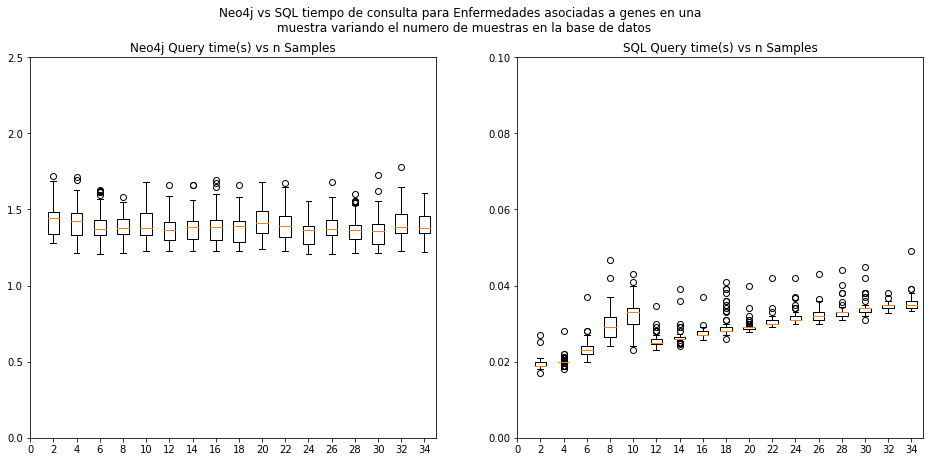

In [303]:
r_D_in_G = D_in_G.iloc[::-1]
r_SQL_D_in_G = SQL_D_in_G.iloc[::-1]
tuples1 = [tuple(x) for x in r_D_in_G.to_numpy()]
tuples2 = [tuple(x) for x in r_SQL_D_in_G.to_numpy()]

d1 = defaultdict(list)
for x, y in tuples1:
    d1[x].append(y)
d2 = defaultdict(list)
for x, y in tuples2:
    d2[x].append(y)

fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(16)
#'Neo4j vs SQL Query time for Genes in 1 Sample varying Samples number in database'
fig.suptitle('Neo4j vs SQL tiempo de consulta para Enfermedades asociadas a genes en una \n muestra variando el numero de muestras en la base de datos')
ax1.boxplot(d1.values())
ax1.title.set_text('Neo4j Query time(s) vs n Samples')
ax1.set_ylim([0, 2.50])
ax2.boxplot(d2.values())
ax2.title.set_text('SQL Query time(s) vs n Samples')
ax2.set_ylim([0, 0.10])
plt.sca(ax1)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.sca(ax2)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.show()

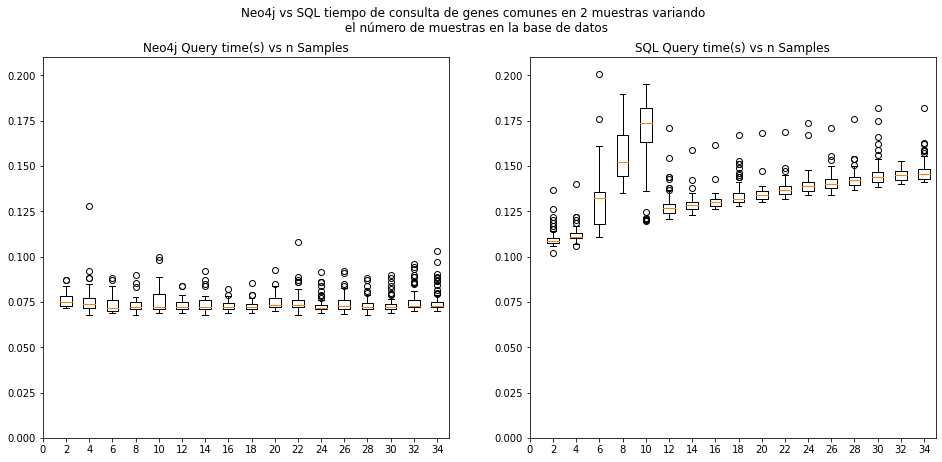

In [304]:
r_G_2_S = G_2_S.iloc[::-1]
r_SQL_G_2_S = SQL_G_2_S.iloc[::-1]
tuples1 = [tuple(x) for x in r_G_2_S.to_numpy()]
tuples2 = [tuple(x) for x in r_SQL_G_2_S.to_numpy()]

d1 = defaultdict(list)
for x, y in tuples1:
    d1[x].append(y)
d2 = defaultdict(list)
for x, y in tuples2:
    d2[x].append(y)

fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(16)
#'Neo4j vs SQL Query time for Genes in 1 Sample varying Samples number in database'
fig.suptitle('Neo4j vs SQL tiempo de consulta de genes comunes en 2 muestras variando \n el número de muestras en la base de datos')
ax1.boxplot(d1.values())
ax1.title.set_text('Neo4j Query time(s) vs n Samples')
ax1.set_ylim([0, 0.210])
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
ax2.boxplot(d2.values())
ax2.title.set_text('SQL Query time(s) vs n Samples')
ax2.set_ylim([0, 0.210])
#ax2. set_yscale([0,0.1,0.15,0.20,0.25,0.3,0.35,0.4])
#plt.xticks([2])
plt.sca(ax1)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.sca(ax2)
plt.xticks(range(18), [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34])
plt.show()

In [306]:
SQL_G_in_S.groupby([0]).mean()


,1
0,
2,0.007868
4,0.009022
6,0.010760
8,0.013462
10,0.015717
12,0.013275
14,0.014136
16,0.015209
18,0.017304


In [307]:
SQL_D_in_G.groupby([0]).mean()


,1
0,
2,0.019342
4,0.020143
6,0.106320
8,0.029265
10,0.171708
12,0.025421
14,0.026354
16,0.027258
18,0.028990


In [308]:
SQL_G_2_S.groupby([0]).mean()

,1
0,
2,0.109754
4,0.112040
6,0.129505
8,0.156253
10,0.168717
12,0.127983
14,0.128934
16,0.130255
18,0.230701


In [305]:
sql_mean_G_in_S

,1
0,
2,0.007868
4,0.009022
6,0.010760
8,0.013462
10,0.015717
12,0.013275
14,0.014136
16,0.015209
18,0.017304
